# UMAP on sparse data

Sometimes datasets get very large, and potentially very very high dimensional. In many such cases, however, the data itself is sparse -- that is, while there are many many features, any given sample has only a small number of non-zero features observed. In such cases the data can be represented much more efficiently in terms of memory usage by a sparse matrix data structure. It can be hard to find dimension reduction techniques that work directly on such sparse data -- often one applies a basic linear technique such as ``TruncatedSVD`` from sklearn (which does accept sparse matrix input) to get the data in a format amenable to other more advanced dimension reduction techniques. In the case of UMAP this is not necessary -- UMAP can run directly on sparse matrix input. This tutorial will walk through a couple of examples of doing this. First we'll need some libraries loaded. We need ``numpy`` obviously, but we'll also make use of ``scipy.sparse`` which provides sparse matrix data structures. One of our examples will be purely mathematical, and we'll make use of ``sympy`` for that; the other example is test based and we'll use sklearn for that (specifically ``sklearn.feature_extraction.text``). Beyond that we'll need umap, and plotting tools.

In [1]:
import numpy as np
import scipy.sparse
import sympy
import sklearn.datasets
import sklearn.feature_extraction.text
import umap
import umap.plot
import matplotlib.pyplot as plt
%matplotlib inline

## A mathematical example

Our first example constructs a sparse matrix of data out of pure math. This example is inspired by the work of [John Williamson](https://johnhw.github.io/umap_primes/index.md.html), and if you haven't looked at that work you are strongly encouraged to do so. The dataset under consideration will be the integers. We will represent each integer by a vector of its divisibility by distinct primes. Thus our feature space is the space of prime numbers (less than or equal to the largest integer we will be considering) -- potentially very high dimensional. In practice a given integer is divisible by only a small number of distinct primes, so each sample will be mostly made up of zeros (all the primes that the number is not divisible by), and thus we will have a very sparse dataset.

To get started we'll need a list of all the primes. Fortunately we have ``sympy`` at our disposal and we can quickly get that information with a single call to ``primerange``. We'll also need a dictionary mapping the different primes to the column number they correspond to in our data structure; effectively we'll just be enumerating the primes.

In [2]:
primes = list(sympy.primerange(2, 110000))
prime_to_column = {p:i for i, p in enumerate(primes)}

Now we need to construct our data in a format we can put into a sparse matrix easily. At this point a little background on sparse matrix data structures is useful. For this purpose we'll be using the so called ["LIL" format](https://scipy-lectures.org/advanced/scipy_sparse/lil_matrix.html). LIL is short for "List of Lists", since that is how the data is internally stored. There is a list of all the rows, and each row is stored as a list giving the column indices of the non-zero entries. To store the data values there is a parallel structure containing the value of the entry corresponding to a given row and column.

To put the data together in this sort of format we need to construct such a list of lists. We can do that by iterating over all the integers up to a fixed bound, and for each integer (i.e. each row in our dataset) generating the list of column indices which will be non-zero. The column indices will simply be the indices corresponding to the primes that divide the number. Since ``sympy`` has a function ``primefactors`` which returns a list of the unique prime factors of any integer we simply need to map those through our dictionary to covert the primes into column numbers.

Parallel to that we'll construct the corresponding structure of values to insert into a matrix. Since we are only concerned with divisibility this will simply be a one in every non-zero entry, so we can just add a list of ones of the appropriate length for each row.

In [3]:
%%time
lil_matrix_rows = []
lil_matrix_data = []
for n in range(100000):
    prime_factors = sympy.primefactors(n)
    lil_matrix_rows.append([prime_to_column[p] for p in prime_factors])
    lil_matrix_data.append([1] * len(prime_factors))

CPU times: user 2.07 s, sys: 26.4 ms, total: 2.1 s
Wall time: 2.1 s


Now we need to get that into a sparse matrix. Fortunately the ``scipy.sparse`` package makes this easy, and we've already built the data in a fairly useful structure. First we create a sparse matrix of the correct format (LIL) and the right shape (as many rows as we have generated, and as many columns as there are primes). This is essentially just an empty matrix however. We can fix that by setting the ``rows`` attribute to be the rows we have generated, and the ``data`` attribute to be the corresponding structure of values (all ones). The result is a sparse matrix data structure which can then be easily manipulated and converted into other sparse matrix formats easily.

In [4]:
factor_matrix = scipy.sparse.lil_matrix((len(lil_matrix_rows), len(primes)), dtype=np.float32)
factor_matrix.rows = np.array(lil_matrix_rows)
factor_matrix.data = np.array(lil_matrix_data)
factor_matrix

<100000x10453 sparse matrix of type '<class 'numpy.float32'>'
	with 266398 stored elements in LInked List format>

As you can see we have a matrix with 100000 rows and over 10000 columns. If we were storing that as a numpy array it would take a great deal of memory. In practice, however, there are only 260000 or so entries that are not zero, and that's all we really need to store, making it much more compact.

The question now is how can we feed that sparse matrix structure into UMAP to have it learn an embedding. The answer is surprisingly straightforward -- we just hand it directly to the fit method. Just like other sklearn estimators that can handle sparse input UMAP will detect the sparse matrix and just do the right thing.

In [5]:
%%time
mapper = umap.UMAP(metric='cosine', random_state=42, low_memory=True).fit(factor_matrix)

CPU times: user 9min 36s, sys: 6.76 s, total: 9min 43s
Wall time: 9min 7s


That was easy! But is it really working? We can easily plot the results:

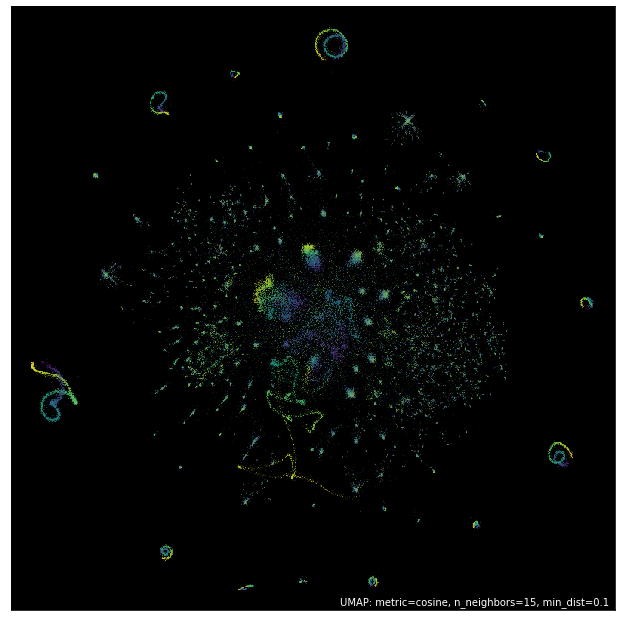

In [6]:
umap.plot.points(mapper, values=np.arange(100000), theme='viridis')

And this looks very much in line with the results [John Williamson got](https://johnhw.github.io/umap_primes/index.md.html) with the proviso that we only used 100,000 integers instead of 1,000,000 to ensure that most users should be able to run this example (the full million may require a large memory compute node). So it seems like this is working well. The next question is whether we can use the ``transform`` functionality to map new data into this space. To test that we'll need some more data. Fortunately there are more integers. We'll grab the next 10,000 and put them in a sparse matrix, much as we did for the first 100,000.

In [7]:
%%time
lil_matrix_rows = []
lil_matrix_data = []
for n in range(100000, 110000):
    prime_factors = sympy.primefactors(n)
    lil_matrix_rows.append([prime_to_column[p] for p in prime_factors])
    lil_matrix_data.append([1] * len(prime_factors))

CPU times: user 214 ms, sys: 1.99 ms, total: 216 ms
Wall time: 222 ms


In [8]:
new_data = scipy.sparse.lil_matrix((len(lil_matrix_rows), len(primes)), dtype=np.float32)
new_data.rows = np.array(lil_matrix_rows)
new_data.data = np.array(lil_matrix_data)
new_data

<10000x10453 sparse matrix of type '<class 'numpy.float32'>'
	with 27592 stored elements in LInked List format>

To map the new data we generated we can simply hand it to the ``transform`` method of our trained model. This is a little slow, but it does work.

In [9]:
new_data_embedding = mapper.transform(new_data)

And we can plot the results. Since we just got the locations of the points this time (rather than a model) we'll have to resort to matplotlib for plotting.

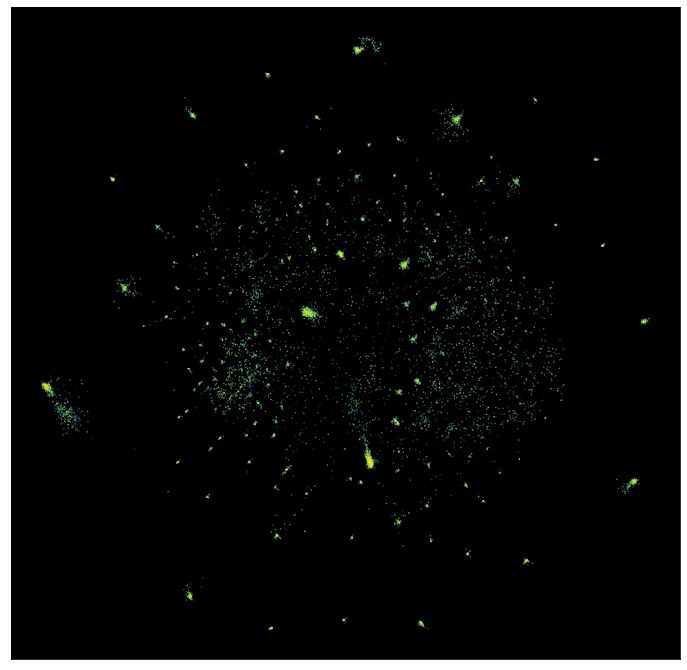

In [10]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
plt.scatter(new_data_embedding[:, 0], new_data_embedding[:, 1], s=0.1, c=np.arange(10000), cmap='viridis')
ax.set(xticks=[], yticks=[], facecolor='black');

The color scale is different in this case, but you can see that the data has been mapped into locations corresponding to the various structures seen in the original embedding. Thus, even with large sparse data we can embed the data, and even add new data to the embedding.

## A text analysis example

Let's look at a more classical machine learning example of working with sparse high dimensional data -- working with text documents. Machine learning on text is hard, and there is a great deal of literature on the subject, but for now we'll just consider a basic approach. Part of the difficulty of machine learning with text is turning language into numbers, since numbers are really all most machine learning algorithms understand (at heart anyway). One of the most straightforward ways to do this for documents is what is known as the ["bag-of-words" model](https://en.wikipedia.org/wiki/Bag-of-words_model). In this model we view a document as simply a multi-set of the words contained in it -- we completely ignore word order. The result can be viewed as a matrix of data by setting the feature space to be the set of all words that appear in any document, and a document is represented by a vector where the value of the *i*th entry is the number of times the *i*th word occurs in that document. This is a very common approach, and is what you will get if you apply sklearn's ``CountVectorizer`` to a text dataset for example. The catch with this approach is that the feature space is often *very* large, since we have a feature for each and every word that ever occurs in the entire corpus of documents. The data is sparse however, since most documents only use a small portion of the total possible vocabulary. Thus the default output format of ``CountVectorizer`` (and other similar feature extraction tools in sklearn) is a ``scipy.sparse`` format matrix.

For this example we'll make use of the classic 20newsgroups dataset, a sampling of newsgroup messages from the old NNTP newsgroup system covering 20 different newsgroups. The ``sklearn.datasets`` module can easily fetch the data, and, in fact, we can fetch a pre-vectorized version to save us the trouble of running ``CountVectorizer`` ourselves. We'll grab both the training set, and the test set for later use.

In [11]:
news_train = sklearn.datasets.fetch_20newsgroups_vectorized(subset='train')
news_test = sklearn.datasets.fetch_20newsgroups_vectorized(subset='test')

If we look at the actual data we have pulled back, we'll see that sklearn has run a ``CountVectorizer`` and produced the data is sparse matrix format.

In [12]:
news_train.data

<11314x130107 sparse matrix of type '<class 'numpy.float64'>'
	with 1787565 stored elements in Compressed Sparse Row format>

The value of the sparse matrix format is immediately obvious in this case; while there are only 11,000 samples there are 130,000 features! If the data were stored in a standard ``numpy`` array we would be using up 10GB of memory! And most of that memory would simply be storing the number zero, over and over again. In sparse matrix format it easily fits in memory on most machines. This sort of dimensionality of data is very common with text workloads.

The raw counts are, however, not ideal since common words the "the" and "and" will dominate the counts for most documents, while contributing very little information about the actual content of the document. We can correct for this by using a ``TfidfTransformer`` from sklearn, which will convert the data into [TF-IDF format](https://en.wikipedia.org/wiki/Tf%E2%80%93idf). There are lots of ways to think about the transformation done by TF-IDF, but I like to think of it intuitively as follows. The information content of a word can be thought of as (roughly) proportional to the negative log of the frequency of the word; the more often a word is used, the less information it tends to carry, and infrequent words carry more information. What TF-IDF is going to do can be thought of as akin to re-weighting the columns according to the information content of the word associated to that column. Thus the common words like "the" and "and" will get down-weighted, as carrying less information about the document, while infrequent words will be deemed more imporant and have their associated columns up-weighted. We can apply this transformation to both the train and test sets (using the same transformer trained on the training set).

In [13]:
tfidf = sklearn.feature_extraction.text.TfidfTransformer(norm='l1').fit(news_train.data)
train_data = tfidf.transform(news_train.data)
test_data = tfidf.transform(news_test.data)

The result is still a sparse matrix, since TF-IDF doesn't change the zero elements at all, nor the number of features.

In [14]:
train_data

<11314x130107 sparse matrix of type '<class 'numpy.float64'>'
	with 1787565 stored elements in Compressed Sparse Row format>

Now we need to pass this very high dimensional data to UMAP. Unlike some other non-linear dimension reduction techniques we don't need to apply PCA first to get the data down to a reasonable dimensionality; nor do we need to use other techniques to reduce the data to be able to be represented as a dense ``numpy`` array; we can work directly on the 130,000 dimensional sparse matrix.

In [15]:
%%time
mapper = umap.UMAP(metric='hellinger', random_state=42).fit(train_data)

CPU times: user 8min 40s, sys: 3.07 s, total: 8min 44s
Wall time: 8min 43s


Now we can plot the results, with labels according to the target variable of the data -- which newsgroup the posting was drawn from.

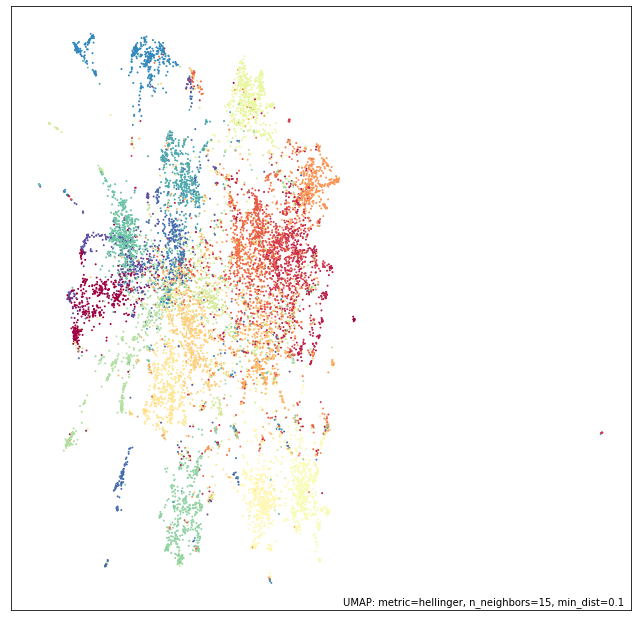

In [16]:
umap.plot.points(mapper, labels=news_train.target)

We can see that even going directly from a 130,000 dimensional space down to only 2 dimensions UMAP has done a decent job of separating out many of the different newsgroups.

We can now attempt to add the test data to the same space using the ``transform`` method. 

In [17]:
test_embedding = mapper.transform(test_data)

While this is somewhat expensive computationally, it does work, and we can plot the end result:

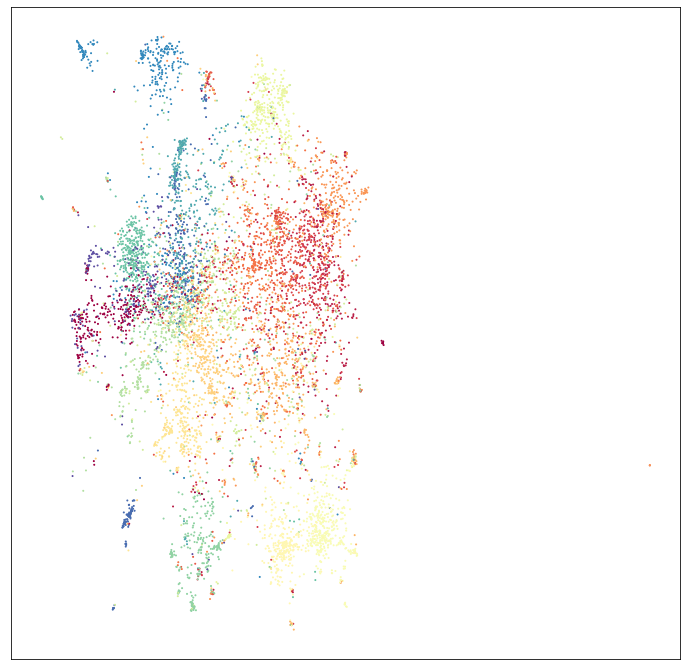

In [18]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
plt.scatter(test_embedding[:, 0], test_embedding[:, 1], s=1, c=news_test.target, cmap='Spectral')
ax.set(xticks=[], yticks=[]);